In [27]:
import pygmt
import numpy as np
import os
import pandas as pd
from pyrocko import util, model, io, trace, gmtpy
import pyrocko.moment_tensor as pmt
from pyrocko.plot import beachball
import matplotlib.pyplot as plt

workdir='../'
catdir =  os.path.join(workdir,'CAT')

switch_VLP=False         ###SWITCH###

if switch_VLP:
    clustydir='../../clusty_flegrei/results_VLP'    
else:
    clustydir='../../clusty_flegrei/results_VT'   

clusty_filename= os.path.join(clustydir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')  ###CHANGE###
           
clusty_events = model.load_events(clusty_filename)

### Open clusty results

In [28]:
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev.extras['color'])

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev.moment_tensor)

if not switch_VLP:
    del cls[-1]     #remove ev not clustered, only for VT

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')

cluster 0 with n ev = 14
cluster 2 with n ev = 4
cluster 1 with n ev = 15
cluster 4 with n ev = 4
cluster 3 with n ev = 4
cluster 5 with n ev = 5
cluster 6 with n ev = 5


### KAGAN moment tensor for each cluster VT

In [29]:
switch_calculate_kagan=False                            ###SWITCH###                       

if switch_calculate_kagan:

    cls_ev = {key: [] for key in cluster_number}
    for ev in clusty_events:
        cls_ev[ev.extras['cluster_number']].append(ev)
    del cls_ev[-1] 
    
    kagan_score_clusters= {key: [] for key in cluster_number}
    del kagan_score_clusters[-1] 
    for key in kagan_score_clusters:
        for ev1 in cls_ev[key]:
            total=0
            n_ev=1
            for ev2 in cls_ev[key]:
                total += pmt.kagan_angle(ev1.moment_tensor, ev2.moment_tensor)
                n_ev += 1
            kagan_score_clusters[key].append( [ [ev1.name ] , [ total/n_ev ] ] )
        kagan_score_clusters[key].sort(key=lambda x: x[1], reverse=False)
    
    for key in kagan_score_clusters:
        print(f'for cluster {key} the event selected is {kagan_score_clusters[key][0][0]} with kagan value :{kagan_score_clusters[key][0][1]}')

for cluster 0 the event selected is ['flegrei_2023_09_07_17_45_28'] with kagan value :[35.28112662382058]
for cluster 2 the event selected is ['flegrei_2023_10_16_10_36_21'] with kagan value :[27.826264926272597]
for cluster 1 the event selected is ['flegrei_2023_06_15_15_39_40'] with kagan value :[29.390214122734708]
for cluster 4 the event selected is ['flegrei_2024_04_06_11_59_31'] with kagan value :[14.043123852897049]
for cluster 3 the event selected is ['flegrei_2023_03_13_22_40_53'] with kagan value :[13.938431368381824]
for cluster 5 the event selected is ['flegrei_2023_09_27_01_35_34'] with kagan value :[32.992366736413246]
for cluster 6 the event selected is ['flegrei_2024_01_21_09_35_04'] with kagan value :[28.327185531083142]


### manually adding Kagan events to new catalogue, then open it

In [30]:
if switch_VLP:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan_VLP.pf')
else:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan.pf')

cat_kagan=model.load_events(cat_kagan_filename)

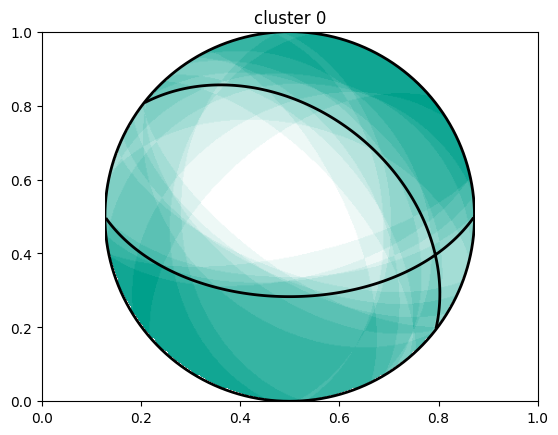

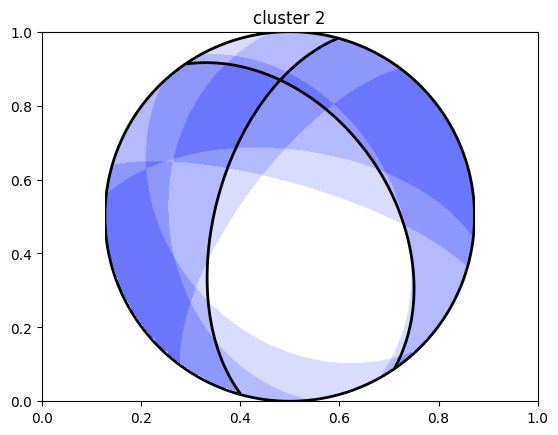

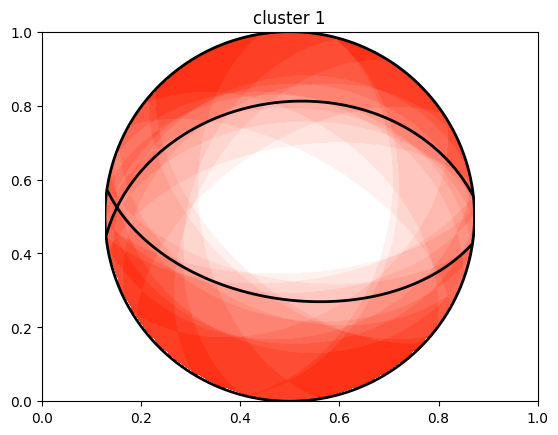

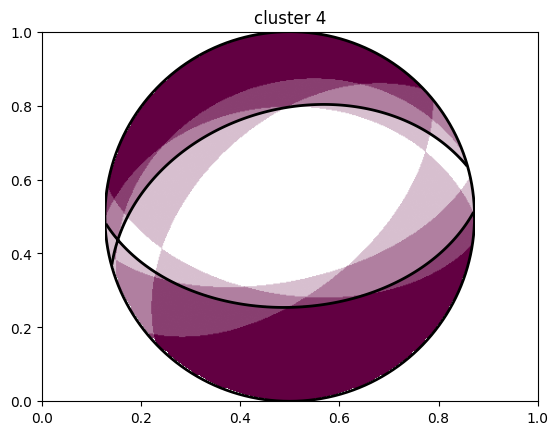

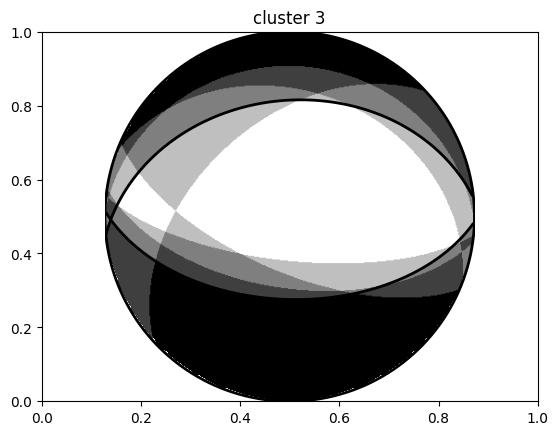

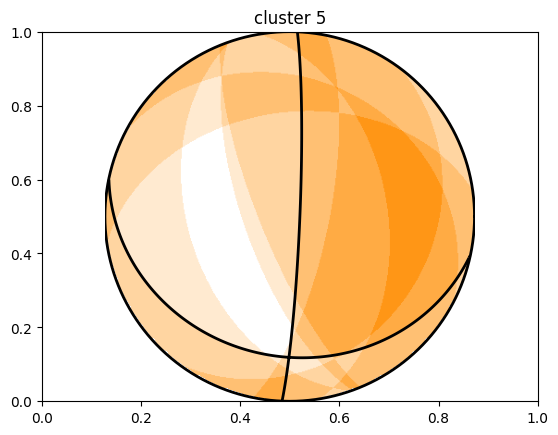

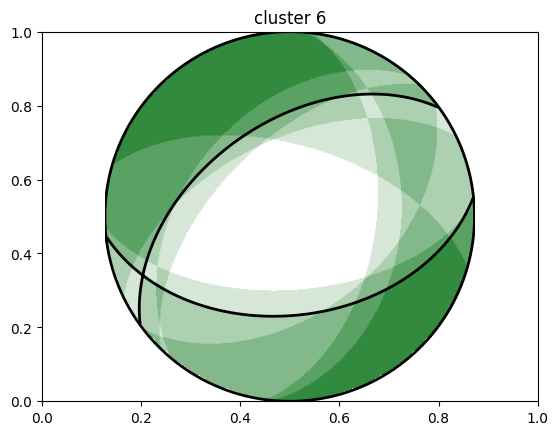

In [31]:
for i,keys in enumerate(cls):
    fig = plt.figure()
    plt.title(f'cluster {keys}')
    axes = fig.add_subplot(1, 1, 1, aspect=1.)
    axes.axison = False
    beachball.plot_fuzzy_beachball_mpl_pixmap(cls[keys], axes, best_mt=cat_kagan[i].moment_tensor, 
        beachball_type='dc', 
        color_t=cluster_color[i], color_p='white', 
        edgecolor='black', best_color='black', linewidth=2, 
        alpha=1.0,grid_resolution=400)
#    beachball.plot_fuzzy_beachball_mpl_pixmap(cls[keys], axes, best_mt=None, 
#        beachball_type='dc', position=(0.0, 0.0), 
#        size=None, zorder=0, color_t='red', color_p='white', 
#        edgecolor='black', best_color='red', linewidth=2, 
#        alpha=1.0, projection='lambert', size_units='data',
#        grid_resolution=400, method='imshow', view='top')
    